# Taylor Swift Pop and Country Songs Audio Features Analysis:

### Background:

The songs that we hear around these days, it is hard to distinguish a country song from a pop song, but is there really a difference between the two?  Are there song features which will be able to classify these two genres?



<br>For this project, we will be extracting Spotify Features via the Spotify API, where the following data will be used:

[Spotify Audio Features](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)
- __acousticness__: describes how many acoustic sounds the track has vs. how many electric sounds [0.0 to 1.0] 
- __danceability__: describes how suitable a track is for dancing based on a combination of musical elements.
  [0.0 least danceable to 1.0 most danceable)
- duration_ms
- __energy__: represents perceptual measure of intensity and activity.  typically energetic feels fast, loud and noisy.
  [0.0 to 1.0]
- instrumentalness
- key
- liveness
- loudness
- mode
- speechiness
- tempo
- time signature
- __valence__: measure from [0.0 to 1.0] describes the musical positiveness conveyed by a track.  Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)

[Spotify Audio Analysis](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-analysis/)
- bar length: a bar or measure is a segment of time as a given number of beats
- beats length: The time interval of beats throughout the track.  A beat is the basic time unit of a piece of music.
- sections length: defined by large ariation in rhythm or timbre e.g. chorus, verse, bridge, guitar solo etc.
- segment length:  each segment contains a roughly consistent sound throughout its duration
  * average & __median pitch__ - values from 0 to 1 that describe the relative dominance of every pitch in the scale.
  * average & __median timbre__ - timbre is the quality of musical note or sound that distinguishes different types of 
    musical instruments or voices.


We will be analyzing songs which have been tagged with the word 'pop' or 'country' from the Million Songs Database https://labrosa.ee.columbia.edu/millionsong/.

and in the end specifically explore if there are differences between Taylor Swift's pre-pop - country songs and her pop songs.


### Problem Definition:

- How does country and pop music differ?  
- Are there differences between the two music genres? -- Can we find some patterns that would differentiate these two music genres? 
- What patterns do we find with the song features?


[additional reference](http://theconversation.com/musical-genres-are-out-of-date-but-this-new-system-explains-why-you-might-like-both-jazz-and-hip-hop-63539)



### Limitations

- since we are relying on the tags from the Million Songs Database to filter out pop and country songs, we can potentially have a 'noisy' data, since we could have jazz, rock songs, or songs with other genres which were added with incorrect tags.  But we should be able to see all these when we try to create clusters for our songs.  

- Because of the limited time, Analysis was done only on the Audio Features from Spotify.



 



### Acquiring Data Set:

Data sets were acquired from the different Sources:

(1) To get the list of Artists, Songs, and genre tags records were extracted from the Million Song Database

https://labrosa.ee.columbia.edu/millionsong/ 

(2) To get audio features of the songs, Spotify API was used, given
the artist name, and song title, the spotify Track ID can be retrieved, which can then be used to query the audio features for the song.


(3) To get the lyrics of the songs, the Genius API will be used, to search the song based on a given Artist Name, and song title.


the following notebooks will show the processing for each of these data acquisition steps:
getArtistSong.ipynb:  get Artist/Songs from Million Song Database
getAudioFeatures.ipynb:    get Audio features via Spotify API
getLyrics.ipynb:      get Song Lyrics via Genius API

and were based on the following Open Source codes:


### Cleaning The Data:

1) Combine the song data collected from Spotify with the Spotify Features, and the Lyrics collected from Genius.
   Only keep records which both Spotify Features, and Lyrics Text from Genius.
   
   
2) The Spotify Features extracted were in JSON format.  Reformatted records to create a column for every Spotify Feature attribute.

3) Added a column 'genre' which was derived based on the tags found from the Song record.  A song was classified as 'pop' if 'pop' occurred in the tag the most, 'country' if 'country' occurred in the tag the most, otherwise, it will be tagged as 'other'.  This column will only be used for verifying output, but cannot provide a good score of accuracy since songs can be mis-tagged.  i.e. Beyonce's song records are tagged with 'country' instead of 'pop'.

4) Lyrics Text were initially cleaned to remove tags, i.e. [Verses], [Chorus]. And used to filter out to only work with songs where Language == English.





In [2]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 2000

In [4]:
### read in files with updated Spotify Features

In [5]:
df = pd.read_pickle('../data/TswiftSongsFeatures.p')

In [12]:
nullidx = df.index[df['bar_len'].isnull()]
df.drop(nullidx, axis=0, inplace=True)

In [13]:
len(df)

44

In [14]:
df.columns

Index(['artist_name', 'title', 'genre', 'spotifyURI', 'songFeatures',
       'bar_len', 'beat_len', 'seg_len', 'pitch_mean', 'pitch_med',
       'timbre_mean', 'timbre_med'],
      dtype='object')

### Exploring Spotify Audio Track Features 

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bar_len,44.0,122.204545,33.651137,73.000000,93.500000,122.500000,142.500000,255.000000
beat_len,44.0,487.431818,134.446738,296.000000,378.500000,481.000000,572.750000,1024.000000
seg_len,44.0,787.977273,106.615259,526.000000,711.250000,775.500000,876.000000,999.000000
pitch_mean,44.0,0.317412,0.046121,0.249674,0.282986,0.307364,0.355630,0.421216
pitch_med,44.0,0.181659,0.062033,0.088500,0.135250,0.167250,0.222312,0.331500
timbre_mean,44.0,5.606703,4.133302,-4.040401,2.912944,5.748246,9.003565,12.340521
timbre_med,44.0,1.755915,2.434629,-3.238500,0.156125,1.584375,3.130000,6.895000


In [16]:
df.reset_index(drop=True, inplace=True)

Format Spotify Features and add columns to DataFrame

In [17]:
for i, row in enumerate(df.itertuples(),start=0):
   # print(row.artist_name_x, row.title_y, row.songFeatures)
    features = row.songFeatures[0]
    #print(features.keys())
    
    #save features as individual column names
    try:
        for key, value in features.items():
            df.set_value(i, key, value)
    except:
        print('error processing features for row {}'.format(i))

In [19]:
nullidx = df.index[df.liveness.isnull()]

df.drop(nullidx, axis=0, inplace=True)

In [20]:
df.reset_index(drop=True,inplace=True)
len(df)

44

In [22]:
### save final cleaned file as pickle file

df.to_pickle('../data/TaylorSwiftSongs_input.p')

## Visualizing and Exploring Features



In [23]:
songsDF = pd.read_pickle('../data/TaylorSwiftSongs_input.p')

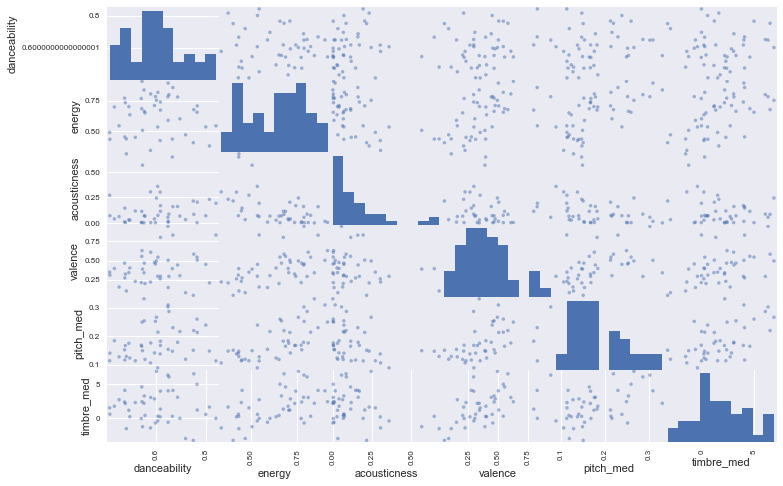

In [24]:
from pandas.plotting import scatter_matrix


features = ['danceability', 'energy', 'acousticness', 'valence', 'pitch_med',  'timbre_med']

scatter_matrix(songsDF[features], figsize=(12, 8))

plt.savefig('../images/features_scatter_matrix.png')

#### Some of the relationships between features we will find from this plot are:
- pitch+timbre - positive correlation
- valence+danceability - positive correlation
- energy+acousticness - negative correlation (high energy - low acoustic)
- energy+pitch - positive correlation

In [25]:
corr_matrix = songsDF[features].corr()

In [26]:
corr_matrix

,danceability,energy,acousticness,valence,pitch_med,timbre_med
danceability,1.000000,-0.038317,0.037016,0.231166,0.247055,-0.005451
energy,-0.038317,1.000000,-0.550471,0.546011,0.689922,0.528942
acousticness,0.037016,-0.550471,1.000000,-0.191358,-0.367443,-0.302154
valence,0.231166,0.546011,-0.191358,1.000000,0.456513,0.503333
pitch_med,0.247055,0.689922,-0.367443,0.456513,1.000000,0.535776
timbre_med,-0.005451,0.528942,-0.302154,0.503333,0.535776,1.000000


In [27]:
country = songsDF[songsDF.genre == 'country']
pop     = songsDF[songsDF.genre == 'pop']

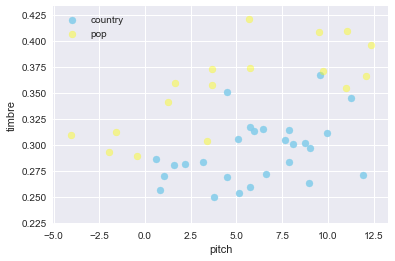

In [28]:
plt.scatter(country['timbre_mean'],country['pitch_mean'],marker='o',color='skyblue',label='country',alpha=0.9)
plt.scatter(pop['timbre_mean'],pop['pitch_mean'],marker='o',color='yellow', label='pop',alpha=0.4)
plt.xlabel('pitch')
plt.ylabel('timbre')
plt.legend()
plt.show()

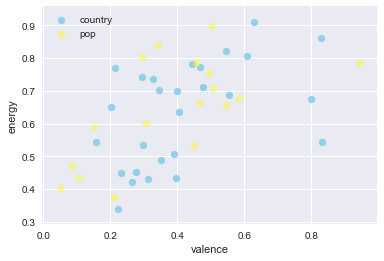

In [29]:
plt.scatter(country['valence'],country['energy'],marker='o',color='skyblue',label='country',alpha=0.9)
plt.scatter(pop['valence'],pop['energy'],marker='o',color='yellow', label='pop',alpha=0.4)
plt.xlabel('valence')
plt.ylabel('energy')
plt.legend()
plt.show()

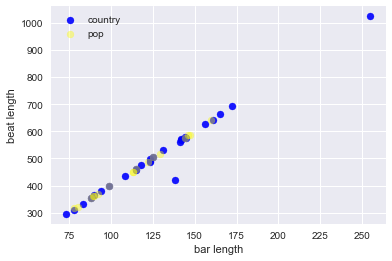

In [30]:
plt.scatter(country['bar_len'],country['beat_len'],marker='o',color='blue',label='country',alpha=0.9)
plt.scatter(pop['bar_len'],pop['beat_len'],marker='o',color='yellow', label='pop',alpha=0.4)
plt.xlabel('bar length')
plt.ylabel('beat length')
plt.legend()
plt.show()

#### The bar length and beat length are similar for the songs tagged as country and pop, and will therefore not be used for the analysis.

## Scale the values of the features, and apply PCA for dimensionality reduction.

The features where we found high correlation were selected to be used for further analysis:
- pitch+timbre - positive correlation
- valence+danceability - positive correlation
- energy+acousticness - negative correlation (high energy - low acoustic)
- energy+pitch - positive correlation

In [31]:
## Scale features before applying PCA.  Features in our dataframe our not standardized, we have some features which 
## are normalized, and some which are not.

from sklearn.preprocessing import StandardScaler


features = ['danceability', 'energy', 'acousticness', 'valence', 'pitch_med',  'timbre_med']

In [32]:
x = songsDF.loc[:, features].values
y = songsDF.loc[:, 'genre'].values

In [33]:
x = StandardScaler().fit_transform(x)

In [34]:
Xtr = x.copy()   #Xtr will be scaled values

In [35]:
from sklearn.decomposition import PCA

#### Determine number of components for PCA

In [36]:
pca = PCA(n_components=None).fit(x)
components = pca.components_
ex_var = pca.explained_variance_ratio_

In [37]:
sums = ex_var.cumsum()
n_comps = 0
for i, s in enumerate(sums):
    if s > 0.9:
        n_comps = i
        break

In [38]:
n_comps

4

In [39]:
comp_range = range(pca.n_components_)

In [40]:
import numpy as np

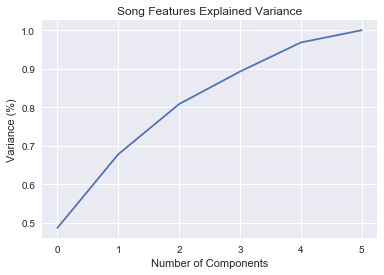

In [41]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Song Features Explained Variance')
plt.show()

In [42]:
data_scaled = pd.DataFrame(Xtr, columns = features)

In [43]:
# transform dataset using n_comps = 2
pca = PCA(n_components=3).fit(Xtr)
x = pca.transform(Xtr)

In [44]:
pca3 = pd.DataFrame(pca.components_, columns=data_scaled.columns, index=['PC-1','PC-2','PC-3']).T
pca3

,PC-1,PC-2,PC-3
danceability,0.094759,0.840626,0.406944
energy,0.512352,-0.200503,0.061857
acousticness,-0.348418,0.386026,-0.681530
valence,0.421653,0.282641,-0.397043
pitch_med,0.485021,0.140367,0.112621
timbre_med,0.440550,-0.067388,-0.442449


### Perform clustering on scaled features Xtr

determine the optimum value of K for clustering

In [45]:
from sklearn.cluster import KMeans

In [46]:
#x4: corresponds to transformed features to PCA for components = 4 

def test(data, nClusterRange):
    inertias = np.zeros(len(nClusterRange))
    for i in range(len(nClusterRange)):
        model = KMeans(n_clusters=i+1, init='k-means++').fit(data)
        inertias[i] = model.inertia_
    return inertias

In [47]:
import numpy as np
kRange = range(1,12)
KmeanTopics = test(Xtr, kRange)

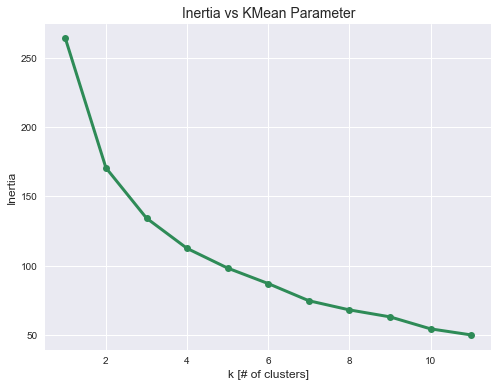

In [48]:
figInertiaWithK = plt.figure(figsize=(8,6))

plt.plot(kRange, KmeanTopics, 'o-', color='seagreen', linewidth=3)
plt.xlabel('k [# of clusters]', size=12)
plt.ylabel('Inertia', size=12)
plt.title('Inertia vs KMean Parameter', size=14)



Let us apply KMeans clustering algorithms using the transformed features and see what patterns/clusters this gives us. 

## KMeans clustering (K = 3) using Scaled features Xtr

In [49]:
km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(Xtr)
cluster_labels = km.labels_
songsDF['K_cluster_n3'] = cluster_labels

In [50]:
songsDF['pca1'] = x[:,0]
songsDF['pca2'] = x[:,1]
songsDF['pca3'] = x[:,2]


In [51]:
c1 = songsDF[songsDF.K_cluster_n3 == 0]
c2 = songsDF[songsDF.K_cluster_n3 == 1]
c3 = songsDF[songsDF.K_cluster_n3 == 2]


### Plotting first 3 components from transformed dataset to visualize the resulting clusters

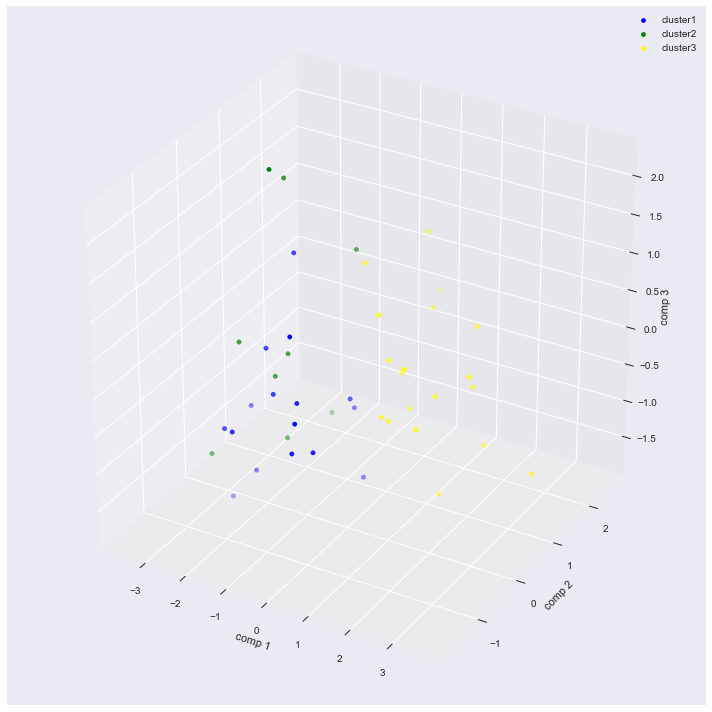

In [55]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fig3d = plt.figure(figsize=(10, 10))
ax = fig3d.add_subplot(111, projection='3d')

p = ax.scatter(c1['pca1'], c1['pca2'], c1['pca3'], color='blue',  label='cluster1')
p = ax.scatter(c2['pca1'], c2['pca2'], c2['pca3'], color='green',  label='cluster2')
p = ax.scatter(c3['pca1'], c3['pca2'], c3['pca3'], color='yellow', label='cluster3')
ax.set_xlabel('comp 1')
ax.set_ylabel('comp 2')
ax.set_zlabel('comp 3')

ax.legend()
fig3d.tight_layout()
plt.savefig('../images/KMeans3D_PCA1_3_N6.png')
#cb = fig3d.colorbar(p)
#cb.set_label('Similarity with (5,5,5)', size=14)

In [56]:
country = songsDF[songsDF.genre == 'country']
pop     = songsDF[songsDF.genre == 'pop']

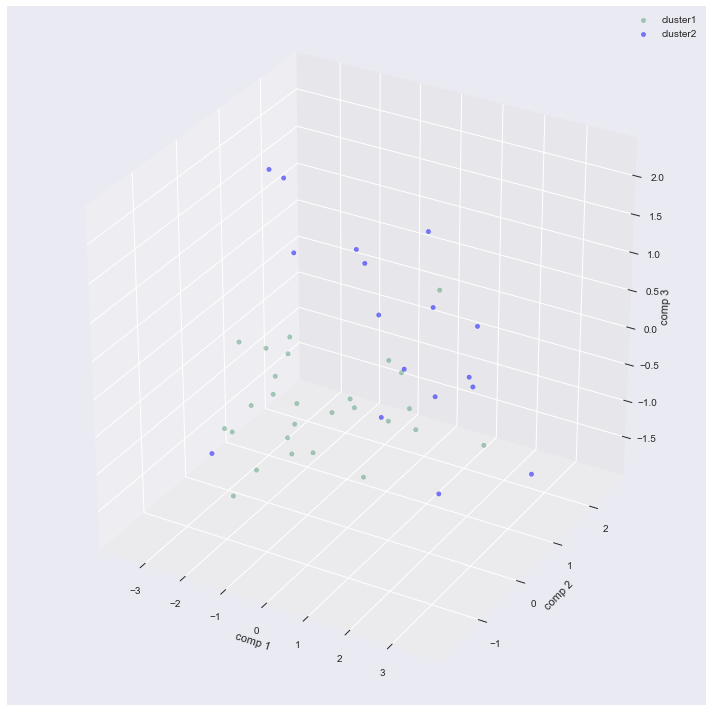

In [57]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fig3d = plt.figure(figsize=(10, 10))
ax = fig3d.add_subplot(111, projection='3d')

p = ax.scatter(country['pca1'], country['pca2'], country['pca3'], color='seagreen', alpha=0.4, label='cluster1')
p = ax.scatter(pop['pca1'], pop['pca2'], pop['pca3'], color='blue', alpha=0.5, label='cluster2')
#p = ax.scatter(c3['pca1'], c3['pca2'], c3['pca3'], color='yellow', alpha=0.2, label='cluster3')
ax.set_xlabel('comp 1')
ax.set_ylabel('comp 2')
ax.set_zlabel('comp 3')

ax.legend()
fig3d.tight_layout()
plt.savefig('../images/KMeans3D_PCA1_3_CountryPop.png')
#cb = fig3d.colorbar(p)
#cb.set_label('Similarity with (5,5,5)', size=14)

## Looking deeper into the resulting cluster features:

### Cluster 0 - high energy, low valence, high pitch, low acoustic

In [58]:
songsDF[songsDF.K_cluster_n3 == 0][features ].describe()  

,danceability,energy,acousticness,valence,pitch_med,timbre_med
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,0.509000,0.628750,0.074341,0.322625,0.145281,1.888422
std,0.070223,0.120248,0.073703,0.117112,0.024267,1.544462
min,0.414000,0.432000,0.004080,0.151000,0.113500,-0.587000
25%,0.468500,0.530250,0.023450,0.227000,0.121938,0.554937
50%,0.493000,0.668500,0.051950,0.319000,0.146500,1.973375
75%,0.546250,0.717750,0.115000,0.399500,0.167125,2.754938
max,0.649000,0.773000,0.272000,0.555000,0.184000,4.598500


### Cluster 1 - High energy, high danceability, high valence, high timbre

In [59]:
songsDF[songsDF.K_cluster_n3 == 1][features ].describe() 

,danceability,energy,acousticness,valence,pitch_med,timbre_med
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,0.642111,0.435667,0.371100,0.224778,0.130361,-0.960306
std,0.105582,0.060739,0.216686,0.126257,0.021962,1.574493
min,0.481000,0.340000,0.032900,0.049900,0.088500,-3.238500
25%,0.578000,0.404000,0.232000,0.107000,0.118750,-1.523000
50%,0.617000,0.434000,0.305000,0.223000,0.137500,-1.237500
75%,0.719000,0.469000,0.567000,0.297000,0.147500,0.211000
max,0.815000,0.534000,0.678000,0.396000,0.150500,1.642750


### Cluster 2 - lower energy, high acoustic, lowest valence, low timbre, low pitch

In [60]:
songsDF[songsDF.K_cluster_n3 == 2][features ].describe()  

,danceability,energy,acousticness,valence,pitch_med,timbre_med
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,0.662000,0.742842,0.085586,0.556579,0.236592,2.930961
std,0.088265,0.111045,0.075949,0.181986,0.053012,2.430715
min,0.544000,0.535000,0.001030,0.295000,0.113000,-0.701500
25%,0.600000,0.669000,0.010715,0.453500,0.213500,0.891750
50%,0.649000,0.783000,0.071300,0.506000,0.239000,3.051000
75%,0.724000,0.814500,0.137500,0.618500,0.263250,4.544000
max,0.841000,0.912000,0.245000,0.943000,0.331500,6.895000


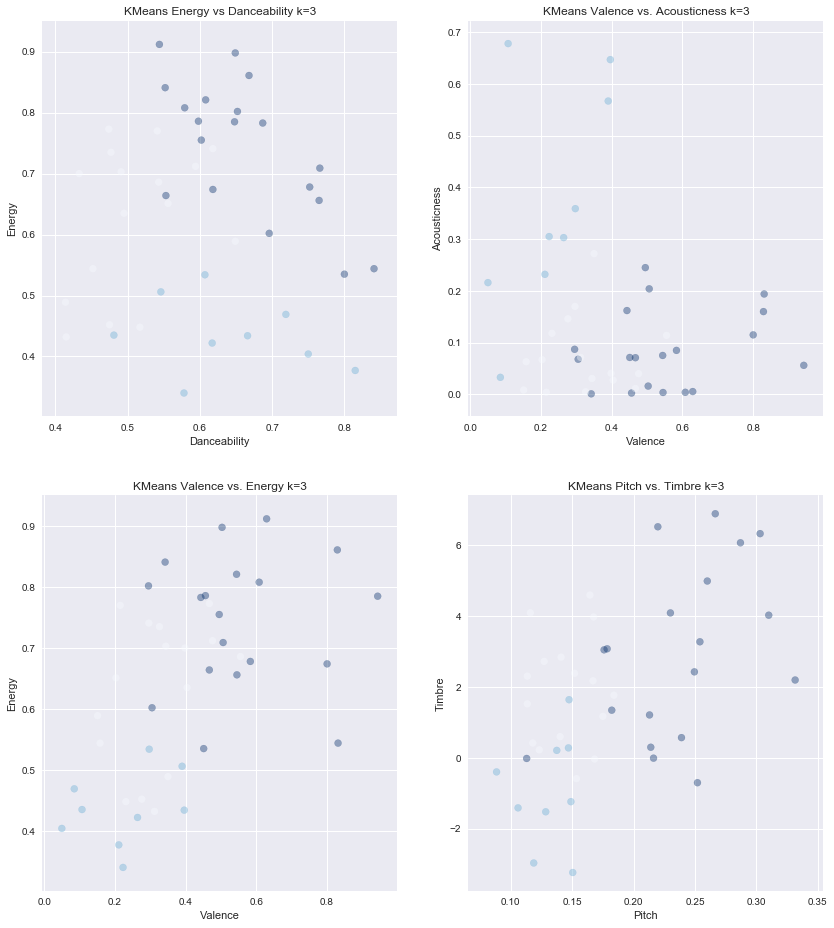

In [61]:
fig = plt.figure(figsize=(14,16))


ax1=plt.subplot(2, 2, 1)
ax1.scatter(songsDF['danceability'],songsDF['energy'],marker='o',c=songsDF['K_cluster_n3'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Danceability')
plt.ylabel('Energy')
ax1.set_title('KMeans Energy vs Danceability k=3')


ax2=plt.subplot(2, 2, 2)
ax2.scatter(songsDF['valence'],songsDF['acousticness'],marker='o',c=songsDF['K_cluster_n3'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Valence')
plt.ylabel('Acousticness')
ax2.set_title('KMeans Valence vs. Acousticness k=3')


ax3=plt.subplot(2, 2, 3)
ax3.scatter(songsDF['valence'],songsDF['energy'],marker='o',c=songsDF['K_cluster_n3'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Valence')
plt.ylabel('Energy')
ax3.set_title('KMeans Valence vs. Energy k=3')

ax4=plt.subplot(2, 2, 4)
ax4.scatter(songsDF['pitch_med'],songsDF['timbre_med'],marker='o',c=songsDF['K_cluster_n3'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3) )
plt.xlabel('Pitch')
plt.ylabel('Timbre')
ax4.set_title('KMeans Pitch vs. Timbre k=3')

plt.savefig('../images/KMeans_FeaturesClusters_K3.png')

In [62]:
km = KMeans(n_clusters=2, random_state=0)
km.fit_transform(Xtr)
cluster_labels = km.labels_
songsDF['K_cluster_n2'] = cluster_labels

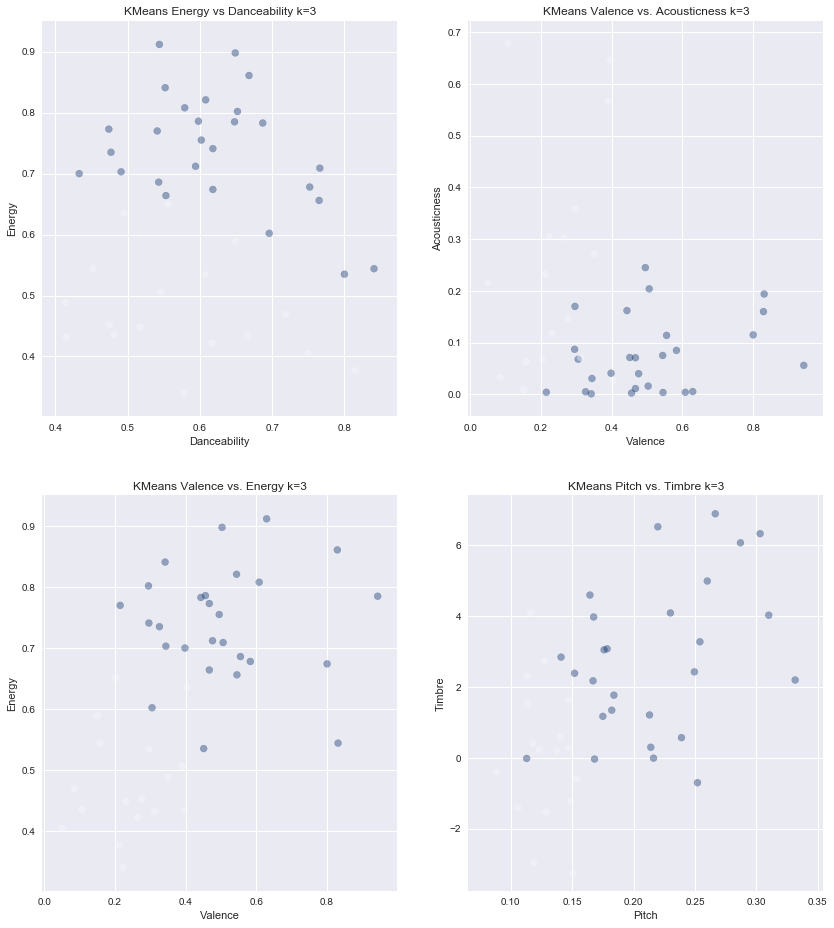

In [63]:
fig = plt.figure(figsize=(14,16))


ax1=plt.subplot(2, 2, 1)
ax1.scatter(songsDF['danceability'],songsDF['energy'],marker='o',c=songsDF['K_cluster_n2'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Danceability')
plt.ylabel('Energy')
ax1.set_title('KMeans Energy vs Danceability k=3')


ax2=plt.subplot(2, 2, 2)
ax2.scatter(songsDF['valence'],songsDF['acousticness'],marker='o',c=songsDF['K_cluster_n2'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Valence')
plt.ylabel('Acousticness')
ax2.set_title('KMeans Valence vs. Acousticness k=3')


ax3=plt.subplot(2, 2, 3)
ax3.scatter(songsDF['valence'],songsDF['energy'],marker='o',c=songsDF['K_cluster_n2'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Valence')
plt.ylabel('Energy')
ax3.set_title('KMeans Valence vs. Energy k=3')

ax4=plt.subplot(2, 2, 4)
ax4.scatter(songsDF['pitch_med'],songsDF['timbre_med'],marker='o',c=songsDF['K_cluster_n2'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3) )
plt.xlabel('Pitch')
plt.ylabel('Timbre')
ax4.set_title('KMeans Pitch vs. Timbre k=3')

plt.savefig('../images/KMeans_FeaturesClusters_K2.png')

In [64]:
songsDF[songsDF.K_cluster_n2 == 0][features ].describe()  

,danceability,energy,acousticness,valence,pitch_med,timbre_med
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,0.573647,0.480059,0.241968,0.241647,0.128147,0.157309
std,0.117775,0.086833,0.215548,0.109298,0.018365,1.944853
min,0.414000,0.340000,0.008450,0.049900,0.088500,-3.238500
25%,0.481000,0.432000,0.067000,0.158000,0.116000,-1.237500
50%,0.556000,0.452000,0.216000,0.231000,0.127250,0.227000
75%,0.649000,0.534000,0.305000,0.312000,0.147000,1.526000
max,0.815000,0.651000,0.678000,0.404000,0.153500,4.098000


In [65]:
songsDF[songsDF.K_cluster_n2 == 1][features ].describe() 

,danceability,energy,acousticness,valence,pitch_med,timbre_med
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,0.620333,0.738296,0.075631,0.505630,0.215352,2.762444
std,0.103770,0.094201,0.072013,0.180667,0.055726,2.179994
min,0.433000,0.535000,0.001030,0.215000,0.113000,-0.701500
25%,0.548000,0.682000,0.008365,0.371000,0.171625,1.192500
50%,0.608000,0.741000,0.067900,0.476000,0.214000,2.429500
75%,0.677500,0.794000,0.114500,0.569000,0.253000,4.061500
max,0.841000,0.912000,0.245000,0.943000,0.331500,6.895000


In [66]:
Top_songs = songsDF.copy()

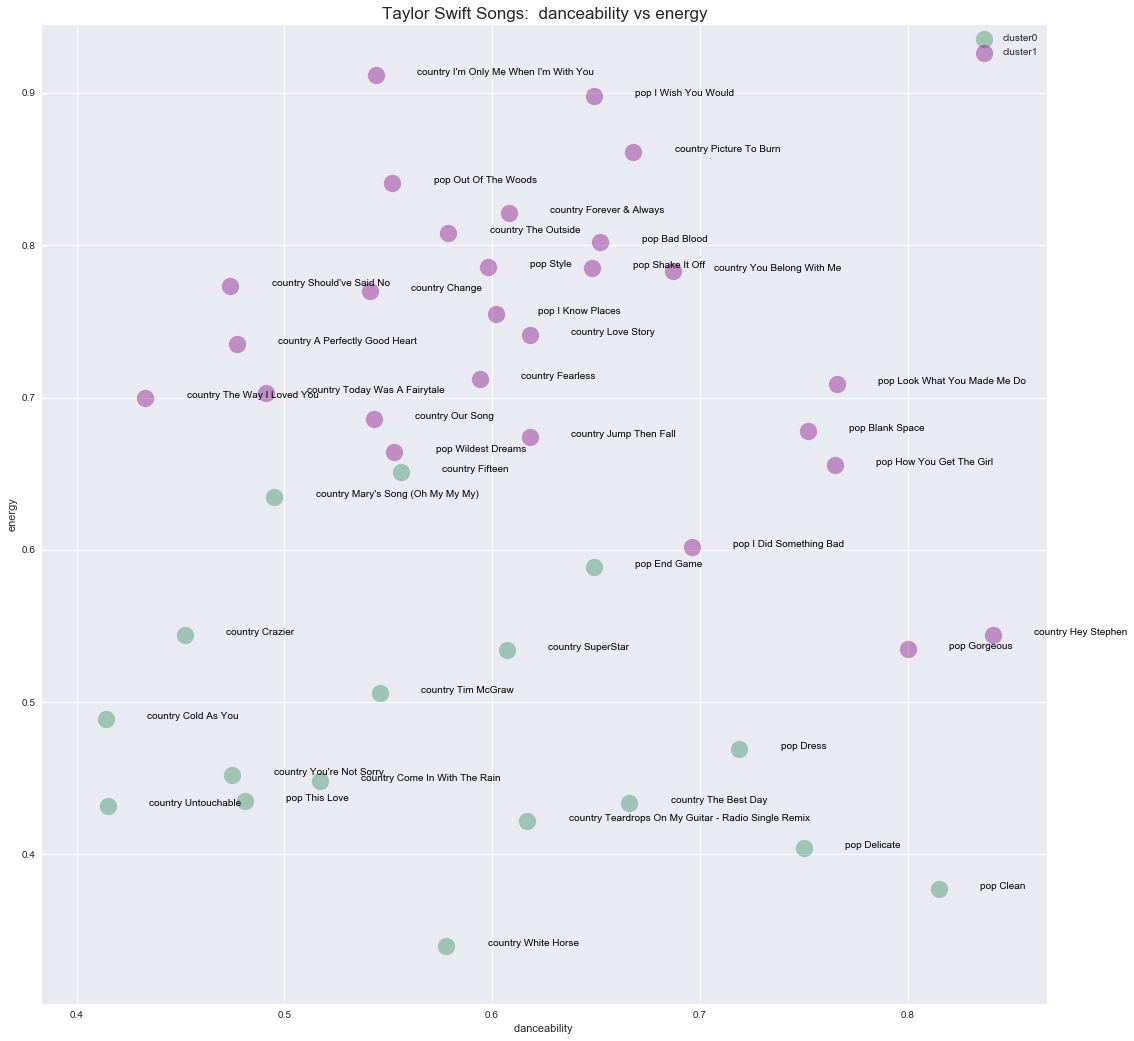

In [70]:
fig = plt.figure(figsize=(18,18))
p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n2 == 0] ,x='danceability', y='energy', fit_reg=False, marker="o", color='seagreen',
                           scatter_kws={'s':300, 'alpha':0.4},label='cluster0')
p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n2 == 1] ,x='danceability', y='energy', fit_reg=False, marker="o", color='purple',
                           scatter_kws={'s':300, 'alpha':0.4},label='cluster1')
#p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n3 == 2] ,x='danceability', y='energy', fit_reg=False, marker="o", color='red',
#                           scatter_kws={'s':300, 'alpha':0.4},label='cluster2')
for line in range(0,Top_songs.shape[0]):
    p1.text(Top_songs.danceability.iloc[line] + 0.02, Top_songs.energy.iloc[line], Top_songs.genre.iloc[line]+' ' +Top_songs.title.iloc[line],
            horizontalalignment='left', size='medium',color='black')
p1.set_xlabel('danceability ')
p1.set_ylabel('energy')
plt.legend()
p1.set_title('Taylor Swift Songs:  danceability vs energy', fontsize=17)
plt.savefig('../images/Songs_dance_energy_Kmeans.png')

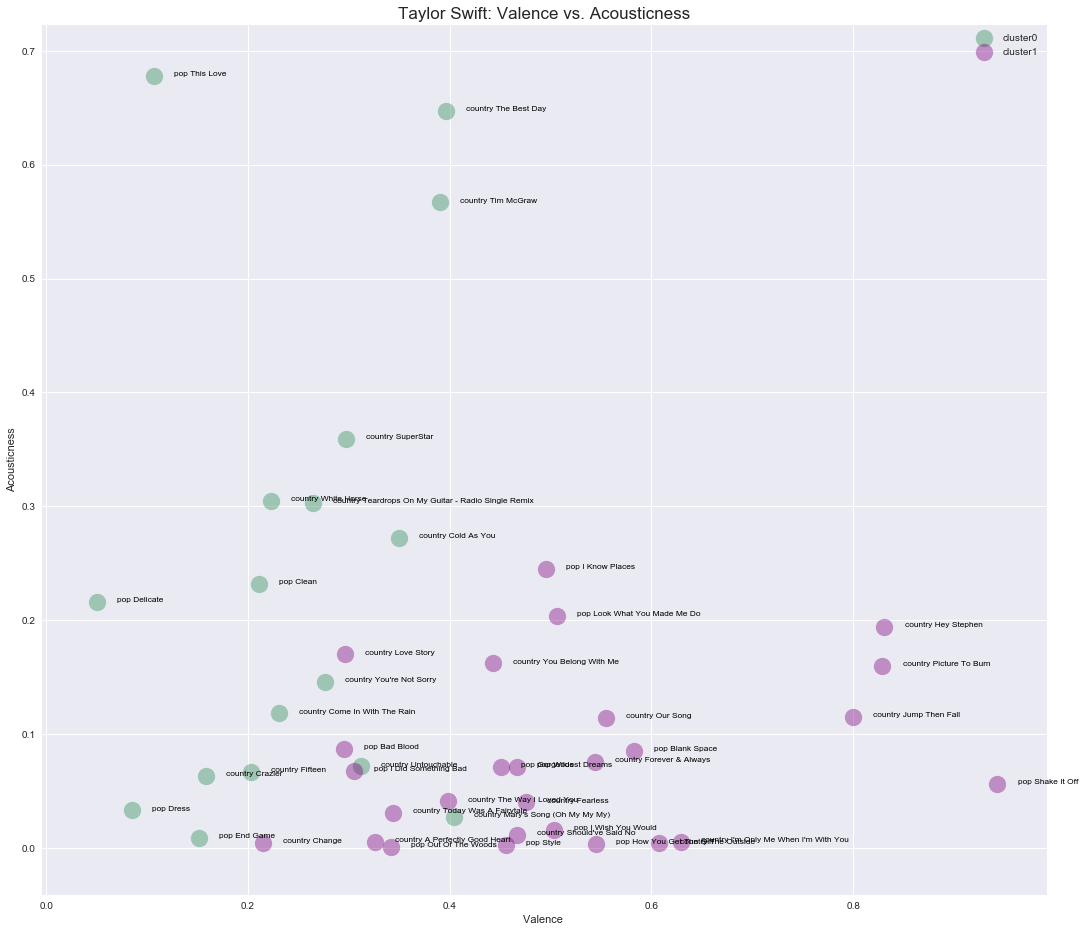

In [71]:
fig = plt.figure(figsize=(18,16))
p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n2 == 0] ,x='valence', y='acousticness', fit_reg=False, marker="o", color='seagreen',
                           scatter_kws={'s':300, 'alpha':0.4},label='cluster0')
p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n2 == 1] ,x='valence', y='acousticness', fit_reg=False, marker="o", color='purple',
                           scatter_kws={'s':300, 'alpha':0.4},label='cluster1')

for line in range(0,Top_songs.shape[0]):
    p1.text(Top_songs.valence.iloc[line] + 0.02, Top_songs.acousticness.iloc[line], Top_songs.genre.iloc[line]+ ' ' +Top_songs.title.iloc[line],
            horizontalalignment='left', size='small',color='black')
p1.set_xlabel('Valence ')
p1.set_ylabel('Acousticness')
plt.legend()
p1.set_title('Taylor Swift: Valence vs. Acousticness', fontsize=17)
plt.savefig('../images/Songs_Valence_Acousticness_Kmeans.png')

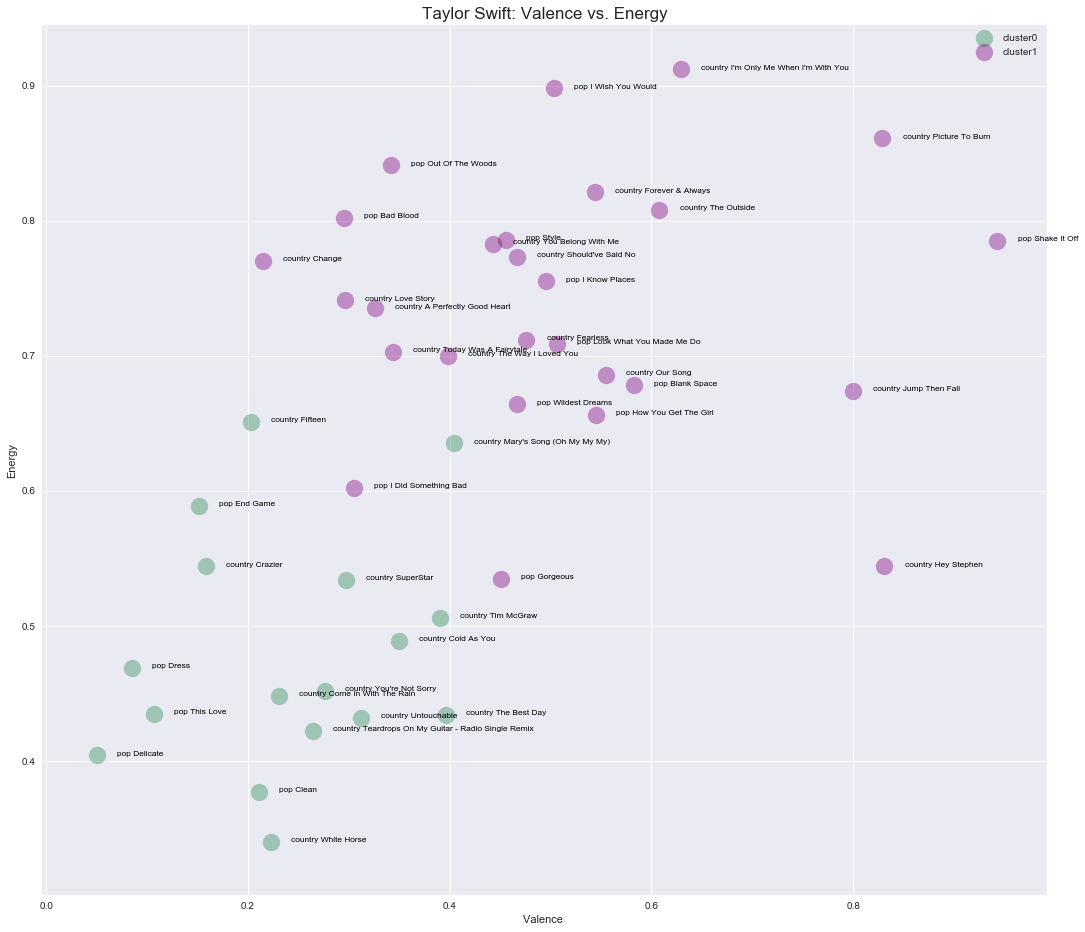

In [75]:
fig = plt.figure(figsize=(18,16))
p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n2 == 0] ,x='valence', y='energy', fit_reg=False, marker="o", color='seagreen',
                           scatter_kws={'s':300, 'alpha':0.4},label='cluster0')
p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n2 == 1] ,x='valence', y='energy', fit_reg=False, marker="o", color='purple',
                           scatter_kws={'s':300, 'alpha':0.4},label='cluster1')
#p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n3_9 == 2] ,x='valence', y='energy', fit_reg=False, marker="o", color='red',
#                           scatter_kws={'s':300, 'alpha':0.4},label='cluster2')
for line in range(0,Top_songs.shape[0]):
    p1.text(Top_songs.valence.iloc[line] + 0.02, Top_songs.energy.iloc[line], Top_songs.genre.iloc[line] +' ' + Top_songs.title.iloc[line],
            horizontalalignment='left', size='small',color='black')
p1.set_xlabel('Valence ')
p1.set_ylabel('Energy')
p1.set_title('Taylor Swift: Valence vs. Energy', fontsize=17)
plt.legend()
plt.savefig('../images/Songs_Valence_Energy_Kmeans.png')

In [77]:
songsDF[(songsDF.K_cluster_n2 == 0)][['artist_name', 'title', 'genre']].sort_values('artist_name')

,artist_name,title,genre
8,Taylor Swift,This Love,pop
40,Taylor Swift,Untouchable,country
38,Taylor Swift,Tim McGraw,country
35,Taylor Swift,The Best Day,country
34,Taylor Swift,Teardrops On My Guitar - Radio Single Remix,country
33,Taylor Swift,SuperStar,country
29,Taylor Swift,Mary's Song (Oh My My My),country
41,Taylor Swift,White Horse,country
23,Taylor Swift,Fifteen,country
20,Taylor Swift,Come In With The Rain,country


In [78]:
songsDF[(songsDF.K_cluster_n2 == 1)][['artist_name', 'title', 'genre']].sort_values('artist_name')

,artist_name,title,genre
0,Taylor Swift,Blank Space,pop
37,Taylor Swift,The Way I Loved You,country
36,Taylor Swift,The Outside,country
32,Taylor Swift,Should've Said No,country
31,Taylor Swift,Picture To Burn,country
30,Taylor Swift,Our Song,country
28,Taylor Swift,Love Story,country
27,Taylor Swift,Jump Then Fall,country
26,Taylor Swift,I'm Only Me When I'm With You,country
25,Taylor Swift,Hey Stephen,country


#### Summarize Results:

In [81]:
def getClusterSummResults(clustLabel, k=3):
    ''' returns a dataframe with summarized results for the clustering method'''
    
    clust_summ = {'cluster':[],'mSong_tag':[],'count':[], 'Pct Overall Genre': []}
    
    total_msong_pop = songsDF[(songsDF.genre == 'pop')].title.count()
    total_msong_country = songsDF[(songsDF.genre == 'country')].title.count()
    
    for num in range(k):
        clust_count_cntry = songsDF[(songsDF[clustLabel] == num) & (songsDF.genre == 'country')].title.count()
        clust_count_pop   = songsDF[(songsDF[clustLabel] == num) & (songsDF.genre == 'pop')].title.count()
    
    
        clust_summ['cluster'].append(num)
        clust_summ['mSong_tag'].append('country')
        clust_summ['count'].append(clust_count_cntry)
        clust_summ['Pct Overall Genre'].append(clust_count_cntry/total_msong_country*100)
    
        clust_summ['cluster'].append(num)
        clust_summ['mSong_tag'].append('pop')
        clust_summ['count'].append(clust_count_pop)
        clust_summ['Pct Overall Genre'].append(clust_count_pop/total_msong_pop*100)

    
    summDF = pd.DataFrame(clust_summ)
    summDF = summDF[['cluster','mSong_tag','count','Pct Overall Genre']].copy()
    return summDF


KMeansDF = getClusterSummResults('K_cluster_n3')
KMeansDF2 = getClusterSummResults('K_cluster_n2',2)


KMeans - K=2

* Cluster 0 - Low Acoustic
* Cluster 1 - High Acoustic

In [82]:
KMeansDF2

,cluster,mSong_tag,count,Pct Overall Genre
0,0,country,12,44.444444
1,0,pop,5,29.411765
2,1,country,15,55.555556
3,1,pop,12,70.588235


In [83]:
KMeansDF

,cluster,mSong_tag,count,Pct Overall Genre
0,0,country,15,55.555556
1,0,pop,1,5.882353
2,1,country,5,18.518519
3,1,pop,4,23.529412
4,2,country,7,25.925926
5,2,pop,12,70.588235


__KMeans Clusters__
- 0 - High Energy, Low Acoustic, Low Danceability, Low Valence, High Pitch
- 1 - High Energy, High Danceability, High Valence, High Timbre
- 2 - High Acoustic, Low Energy, Low Timbre, Low Pitch, Low Valence




 <br>* *majority of the country songs are classified as cluster 2
 <br>* *majority of the pop songs are classified as cluster 1
 <br>* *cluster 3 appears to be the most common features 'overlap' between country and pop songs 

In [176]:
songsDF['year'] = songsDF.year.astype(int)

In [177]:
songsDF.groupby(['K_cluster_n3','genre']).year.agg(['min','max','median','mean'])

min   max  median         mean
K_cluster_n3 genre                                   
0            country  1990  2010    2005  2004.115847
             pop      1990  2010    2005  2003.438479
1            country  1990  2010    2004  2002.338164
             pop      1990  2010    2004  2002.841502
2            country  1990  2010    2005  2003.260371
             pop      1990  2010    2005  2003.324868

In [178]:
songsDF[(songsDF.artist_hotttnesss > .5)].groupby('K_cluster_n3').year.agg(['min','max','median','mean'])

,min,max,median,mean
K_cluster_n3,,,,
0,1990,2010,2006,2005.346154
1,1990,2010,2005,2004.248217
2,1990,2010,2005,2004.349892


In [179]:
songsDF[(songsDF.artist_hotttnesss > .5) & (songsDF.K_cluster_n3 == 2) & (songsDF.genre == 'pop')].describe().T

,count,mean,std,min,25%,50%,75%,max
level_0,290.0,9245.589655,5901.534114,73.000000,4359.250000,7668.500000,13839.750000,19622.000000
index,290.0,6253.544828,3396.562483,125.000000,3803.750000,5755.500000,9448.500000,12084.000000
duration,290.0,226.234277,69.688444,1.044440,191.953827,227.944035,265.155465,543.842810
artist_familiarity,290.0,0.772423,0.056024,0.635166,0.737437,0.761015,0.796505,0.947328
artist_hotttnesss,290.0,0.573291,0.062169,0.500661,0.527761,0.567507,0.600323,0.804220
year,290.0,2004.920690,4.614996,1990.000000,2003.000000,2006.000000,2008.000000,2010.000000
FKRG1,290.0,65.219172,7.000344,50.210000,60.537500,64.610000,69.770000,97.650000
fkrg_sent1,290.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
FKRG2,290.0,5.070966,6.827254,-5.660000,1.007500,3.785000,7.897500,54.220000
fkrg_sent2,290.0,23.251724,11.840436,1.000000,14.000000,23.000000,30.000000,66.000000


In [91]:
songsDF.columns

Index(['level_0', 'index', 'artist_id', 'tags', 'track_id', 'title', 'song_id',
       'release', 'artist_mbid', 'artist_name', 'duration',
       'artist_familiarity', 'artist_hotttnesss', 'year', 'track_7digitalid',
       'shs_perf', 'shs_work', 'lyrics_text', 'spotifyURI', 'songFeatures',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'genre', 'country_count', 'pop_count', 'other_count',
       'language', 'lyrics_clean', 'FKRG1', 'fkrg_sent1', 'FKRG2',
       'fkrg_sent2', 'bar_len', 'beat_len', 'seg_len', 'pitch_mean',
       'pitch_med', 'timbre_mean', 'timbre_med', 'K_cluster_n3', 'pca1',
       'pca2', 'K_cluster_n2'],
      dtype='object')

In [96]:
songsDF['year'] = songsDF.year.astype(int)

In [99]:
songsDF.head()

,level_0,index,artist_id,tags,track_id,title,song_id,release,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work,lyrics_text,spotifyURI,songFeatures,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre,country_count,pop_count,other_count,language,lyrics_clean,FKRG1,fkrg_sent1,FKRG2,fkrg_sent2,bar_len,beat_len,seg_len,pitch_mean,pitch_med,timbre_mean,timbre_med,K_cluster_n3,pca1,pca2,K_cluster_n2
0,0,0.0,AR009211187B989185,"[(pop rock,), (pop,), (synthpop,), (reggae pop,)]",TRDBNUI128F933DE6E,I'm So Sorry,SOZCBYK12AB0180B4D,The Best Of Original British Lovers Rock Volum...,9dfe78a6-6d91-454e-9b95-9d7722cbc476,Carroll Thompson,260.91057,0.396818,0.297405,2007,6144722,-1,0,Gabrielle\nGabrielle\nI'm So Glad\nI can never...,4EPZgfbYO1gjE7LeiNBLtx,"[{'danceability': 0.862, 'energy': 0.34, 'key'...",0.803,0.994,0.0,-4.202,1.0,0.1740,0.004290,0.463000,0.0432,0.0384,141.081,audio_features,19mWMfe0fX4lm3V4fXkyA6,spotify:track:19mWMfe0fX4lm3V4fXkyA6,https://api.spotify.com/v1/tracks/19mWMfe0fX4l...,https://api.spotify.com/v1/audio-analysis/19mW...,426520.0,4.0,pop,0.0,4.0,0.0,en,Gabrielle\nGabrielle\nI'm So Glad\nI can never...,66.73,1.0,3.90,34.0,146.0,587.0,1069.0,0.314259,0.1725,4.253335,3.78950,1,-0.916813,-0.185845,1
1,1,1.0,AR00FOZ1187FB5C9F3,"[(synthpop,), (pop,), (pukkelpop,)]",TRWTSUW12903CD2DEA,Stay The Same,SOBGFYV12AB018DEAD,Stay The Same,92337972-f0c5-4ebd-be8c-f6b23d596ae1,autoKratz,404.97587,0.632410,0.499475,2008,6548152,-1,0,"We can't always stay the same, but we all keep...",1gZ4TP1pQwRD5WhYKDG0jw,"[{'danceability': 0.602, 'energy': 0.733, 'key...",0.641,0.801,7.0,-4.179,0.0,0.0302,0.002870,0.002620,0.0716,0.9160,127.000,audio_features,1wZY4LPJsABndQeoqzsyOX,spotify:track:1wZY4LPJsABndQeoqzsyOX,https://api.spotify.com/v1/tracks/1wZY4LPJsABn...,https://api.spotify.com/v1/audio-analysis/1wZY...,283333.0,4.0,pop,0.0,3.0,0.0,en,"We can't always stay the same, but we all keep...",53.16,1.0,4.61,4.0,168.0,671.0,1196.0,0.439493,0.3505,9.440765,1.97025,1,-2.388036,-1.153280,1
2,4,4.0,AR00FOZ1187FB5C9F3,"[(synthpop,), (pop,), (pukkelpop,)]",TRTMPTG128F92F00A0,Always More,SOUQQXB12A8C140687,Animal,92337972-f0c5-4ebd-be8c-f6b23d596ae1,autoKratz,255.26812,0.632410,0.499475,2009,5334937,-1,0,"Faith I'm sure, there's something wanting but ...",6PWoHhgOdh2gAn0FUAdbff,"[{'danceability': 0.596, 'energy': 0.976, 'key...",0.602,0.733,4.0,-4.019,0.0,0.3600,0.000056,0.000032,0.2270,0.4720,129.943,audio_features,1gZ4TP1pQwRD5WhYKDG0jw,spotify:track:1gZ4TP1pQwRD5WhYKDG0jw,https://api.spotify.com/v1/tracks/1gZ4TP1pQwRD...,https://api.spotify.com/v1/audio-analysis/1gZ4...,311200.0,4.0,pop,0.0,3.0,0.0,en,"Faith I'm sure, there's something wanting but ...",62.96,1.0,1.81,18.0,125.0,503.0,1178.0,0.390729,0.2810,10.661231,3.32725,1,-1.391550,-0.193122,1
5,8,9.0,AR00TGQ1187B994F29,"[(brazilian pop music,), (pop rock,), (pop,), ...",TRIALWQ128F930725A,All Over,SOQHCUX12AB01803B5,SóNós,e61a882e-cee2-4aa9-8d73-bee3c85a44c0,Paula Toller,202.65751,0.530135,0.399928,2007,5917832,-1,0,You won't tear your soul apart\nFrom youself\n...,5VbTkLx44JnBCY4biW6f12,"[{'danceability': 0.766, 'energy': 0.541, 'key...",0.649,0.468,7.0,-9.457,1.0,0.0274,0.649000,0.002940,0.1170,0.2860,135.098,audio_features,1qMSzVussoDbxPQtvFBLfB,spotify:track:1qMSzVussoDbxPQtvFBLfB,https://api.spotify.com/v1/tracks/1qMSzVussoDb...,https://api.spotify.com/v1/audio-analysis/1qMS...,130000.0,3.0,pop,0.0,4.0,0.0,en,You won't tear your soul apart\nFrom youself\n...,60.01,1.0,-0.43,15.0,107.0,434.0,727.0,0.316258,0.1920,-1.197713,-1.27250,2,1.300293,-0.531721,0
6,9,12.0,AR00Y9I1187B999412,"[(pop rock,)]",TRWTMKM12903CDF74A,Praise The Name Of Satan,SOGNOQV12A58A7DF11,Choronzon,fc1abced-ff90-4a42-9998-2e18cceef041,Akercocke,430.81098,0.604705,0.400269,2003,7574066,-1,0,Mephistopheles\nExtract from concealment\nEnli...,

In [180]:
AggCompleteDF

,cluster,mSong_tag,count,Pct Overall Genre
0,0,country,1445,46.869932
1,0,pop,1391,49.714081
2,1,country,1528,49.562115
3,1,pop,1351,48.284489
4,2,country,110,3.567953
5,2,pop,56,2.001430


__Agglomerative Linkage: Complete__
- 0 - High Acoustic, Low Energy, Low Timbre, Low Pitch, Low Valence
- 1 - High Energy, High Danceability, High Valence, High Timbre
- 2 - High Energy, Low Acoustic, Low Danceability, Low Valence, High Pitch



In [181]:
AggWardDF

,cluster,mSong_tag,count,Pct Overall Genre
0,0,country,927,30.068115
1,0,pop,890,31.808435
2,1,country,930,30.165423
3,1,pop,751,26.840600
4,2,country,1226,39.766461
5,2,pop,1157,41.350965


__Agglomerative Linkage: Ward__
- 0 - High Energy, High Danceability, High Valence, High Timbre
- 1 - High Acoustic, Low Energy, Low Timbre, Low Pitch, Low Valence
- 2 - High Energy, Low Acoustic, Low Danceability, Low Valence, High Pitch

### Findings:

1) The cluster characteristics produced by the three different cluster methods were similar.  Main clusters can be described with the following features:

- lower energy, high acoustic, lowest valence, low timbre, low pitch
- high energy, low valence, high pitch, low acoustic
- High energy, high danceability, high valence, high timbre

2) With the audio features we were able to collect, none of these features could clearly distinguish a country song from a Pop song, although majority of Country songs are classified under the cluster with (lower energy, high acoustic, lowest valence, low timbre, low pitch), while majority of the Pop songs are classified under the cluster with (high energy, low valence, high pitch, low acoustic).

3) Looking at the scatter plots for the results of the different clustering methods, the results from KMeans appear to have more distinct clusters between the different features which were plotted out.  

4) Classification of songs between KMeans and Agglomerate Clustering with Linkage = 'complete appear to be more consistent, where majority of the country songs are classified under the cluster with features (High Acoustic, Low Energy, Low Timbre, Low Pitch, Low Valence), and majority of pop songs were classified under the cluster with features (High Energy, Low Acoustic, Low Danceability, Low Valence, High Pitch).  Whereas for Agglomerate clustering wih linkage = 'ward', even if the cluster features are the same, it classified the songs differently.  Majority of the songs were classified in the 'overlap' class -- with features: High Energy, High Danceability, High Valence, High Timbre.



### Next Steps:

Evaluate clusters...formulate conclusion.